In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import yaml
import ast
from pathlib import Path
from functools import partial
from IPython.display import Audio
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
import librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset


experiment_path = Path('../../experiments/UrbanSound_ESC-PANN-tag/')
print(experiment_path)

categories = json.load(open(str(experiment_path / 'index_to_name.json')))
model = torch.load(str(experiment_path / 'model.pt'))
model.eval()
params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))

class Vicente(Dataset):
    def __init__(self, categories):
        self.file_paths = []
        self.meta = pd.read_csv('../../datasets/Vicente/Metadata.csv', 
                                encoding='latin-1', sep=';', header=0, comment='#', parse_dates=[4])
        self.labels = []
        self.folder = []
        for file in Path('../../datasets/Vicente/').rglob('*.wav'):
            tag = self.match_ids(file)["Tag 1"].apply(lambda x: x.split(':')[0] if isinstance(x, str) else None)
            if len(tag) == 0:
                #print(id, file, tag)
                continue
            self.labels.append(tag.item())
            self.file_paths.append(file)
            self.folder.append(file.parent.stem)
        self.categories = categories
    
    def match_ids(self, file_name):
        id = file_name.stem
        if id[-3:] == '(1)':
            id = id[:-3]
        return self.meta.loc[self.meta['Id'] == id]         
        
    def __getitem__(self, idx):
        #return self.file_paths[idx], 'dog'
        return self.file_paths[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.file_paths)
    
mel_transform_pann = MelSpectrogram(sample_rate=params['features']["sampling_rate"],
                                    n_fft=1024, hop_length=320, n_mels=64, normalized=False)
dataset = Vicente(list(categories.values()))
fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), params)
get_rms = partial(librosa.feature.rms, frame_length=1024, hop_length=320)

../../experiments/UrbanSound_ESC-PANN-tag


'1653626700_1653626760.wav'

Id                  Tag 1                    Tag 2  \
16  1653626700_1653626760  vehicles/others:0.491  environmental/wind:0.33   

               Tag 3        Fecha y hora  
16  animal/dog:0.166 2022-05-27 04:45:00

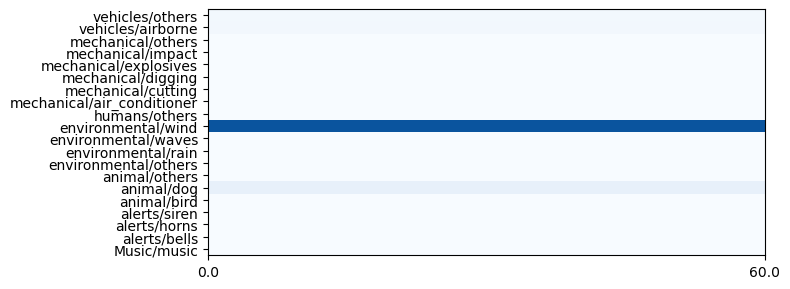

In [2]:
sample = fusa_dataset[3]
display(sample['filename'])
display(dataset.match_ids(Path(sample['filename'])))

window_size = 32000*10*6
preds = []
with torch.no_grad():
    for i in range(sample['waveform'].shape[-1]//window_size):
        sample_small = {'waveform': sample['waveform'][:, i*window_size:(i+1)*window_size].unsqueeze(0)}
        preds.append(torch.nn.Softmax(dim=1)(model(sample_small)).detach().numpy())
preds = np.stack(preds)[:, 0, :]
        
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.pcolormesh(preds.T, vmin=0, vmax=1, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(preds.shape[0]+1))
ax.set_xticklabels(np.linspace(0, 60, num=preds.shape[0]+1))
ax.set_yticks(np.arange(len(fusa_dataset.categories))+0.5)
ax.set_yticklabels(fusa_dataset.categories);
display(Audio(sample['waveform'], rate = params['features']["sampling_rate"]))